<a href="https://colab.research.google.com/github/Ashonet/Trading_Backtest_Analysis/blob/main/Trading_Bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed


Buy 1596 shares at $6.26 on 2020-02-07
Sell 1596 shares at $6.73 on 2020-02-28 | P&L: $740.69 | Cash: $10740.69
Buy 1706 shares at $6.30 on 2020-03-27
Stop-loss sell 1706 shares at $6.05 on 2020-04-01 (bought at $6.30) | P&L: $-410.53 | Cash: $10330.16
Buy 765 shares at $13.49 on 2020-09-30
Stop-loss sell 765 shares at $13.03 on 2020-10-02 (bought at $13.49) | P&L: $-357.20 | Cash: $9972.97
Buy 686 shares at $14.52 on 2020-11-06
Stop-loss sell 686 shares at $13.59 on 2020-11-09 (bought at $14.52) | P&L: $-637.03 | Cash: $9335.93
Buy 697 shares at $13.38 on 2020-11-17
Stop-loss sell 697 shares at $13.05 on 2020-11-20 (bought at $13.38) | P&L: $-232.49 | Cash: $9103.45
Buy 673 shares at $13.52 on 2020-12-04
Stop-loss sell 673 shares at $12.90 on 2020-12-09 (bought at $13.52) | P&L: $-421.24 | Cash: $8682.21
Buy 655 shares at $13.24 on 2020-12-18
Sell 655 shares at $12.98 on 2020-12-23 | P&L: $-171.66 | Cash: $8510.54
Buy 642 shares at $13.24 on 2021-01-08
Stop-loss sell 642 shares at $12

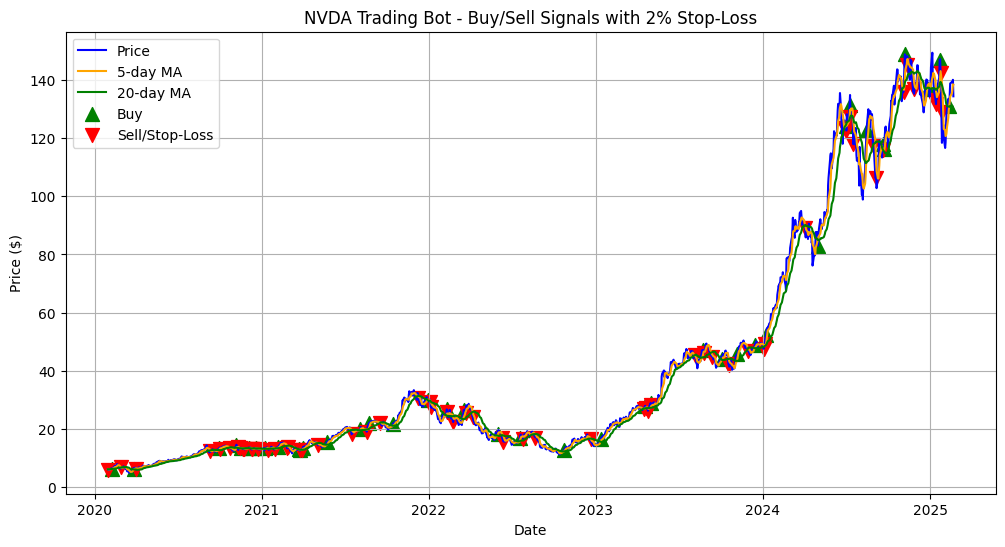

Final cash: $30.63, Shares: 376, Portfolio value: $50576.31


In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Fetch historical data
stock_symbol = "NVDA"
start_date = "2020-01-01"
end_date = "2025-02-22"
data = yf.download(stock_symbol, start=start_date, end=end_date)

# Check if data loaded
if data.empty:
    print("No data fetched. Check internet or symbol.")
    exit()

# Calculate moving averages
data['Short_MA'] = data['Close'].rolling(window=5).mean()
data['Long_MA'] = data['Close'].rolling(window=20).mean()

# Drop rows with NaN values due to MA calculation
data.dropna(inplace=True)

# Generate trading signals for crossover
data['Signal'] = 0  # Default: no action
data['Prev_Short_MA'] = data['Short_MA'].shift(1)
data['Prev_Long_MA'] = data['Long_MA'].shift(1)

# Buy: Previous Short_MA < Long_MA, now Short_MA > Long_MA
data.loc[(data['Prev_Short_MA'] < data['Prev_Long_MA']) &
         (data['Short_MA'] > data['Long_MA']), 'Signal'] = 1

# Sell: Previous Short_MA > Long_MA, now Short_MA < Long_MA
data.loc[(data['Prev_Short_MA'] > data['Prev_Long_MA']) &
         (data['Short_MA'] < data['Long_MA']), 'Signal'] = -1

data['Position'] = data['Signal']  # Direct signal usage

# Simulate trading with stop-loss
cash = 10000.0  # Float to avoid dtype issues
shares = 0
buy_price = 0.0  # Track purchase price for stop-loss
data['Portfolio'] = cash

for i in range(1, len(data)):
    price = data['Close'].iloc[i].item()

    # Check stop-loss if holding shares
    if shares > 0 and price < buy_price * 0.98:  # 2% loss threshold
        # Calculate P&L from stop-loss trade
        pnl = shares * (price - buy_price)
        cash += shares * price
        print(f"Stop-loss sell {shares} shares at ${price:.2f} on {data.index[i].date()} (bought at ${buy_price:.2f}) | P&L: ${pnl:.2f} | Cash: ${cash:.2f}")
        shares = 0
        data.loc[data.index[i], 'Position'] = -1  # Mark as sell for plotting

    # Regular buy/sell based on MA crossover
    elif data['Position'].iloc[i] == 1 and cash >= price:  # Buy
        shares = int(cash / price)
        cash -= shares * price
        buy_price = price  # Record buy price for stop-loss
        print(f"Buy {shares} shares at ${price:.2f} on {data.index[i].date()}")

    elif data['Position'].iloc[i] == -1 and shares > 0:  # Sell
        # Calculate P&L from selling shares
        pnl = shares * (price - buy_price)
        cash += shares * price
        print(f"Sell {shares} shares at ${price:.2f} on {data.index[i].date()} | P&L: ${pnl:.2f} | Cash: ${cash:.2f}")
        shares = 0

    # Update portfolio value after each trade
    data.loc[data.index[i], 'Portfolio'] = cash + shares * price

# Debug: Check signal counts
print(f"Buy signals: {len(data[data['Position'] == 1])}")
print(f"Sell signals (incl. stop-loss): {len(data[data['Position'] == -1])})")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Price', color='blue')
plt.plot(data.index, data['Short_MA'], label='5-day MA', color='orange')
plt.plot(data.index, data['Long_MA'], label='20-day MA', color='green')

# Mark buy/sell points
buy_signals = data[data['Position'] == 1]
sell_signals = data[data['Position'] == -1]
plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Buy', s=100)
plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='Sell/Stop-Loss', s=100)

plt.title(f"{stock_symbol} Trading Bot - Buy/Sell Signals with 2% Stop-Loss")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid()
plt.show()

# Final results
print(f"Final cash: ${cash:.2f}, Shares: {shares}, Portfolio value: ${data['Portfolio'].iloc[-1]:.2f}")


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

# List of Dow 30 stocks (symbols)
dow_30_stocks = [
    "AAPL", "AMGN", "AXP", "BA", "CAT", "CSCO", "CVX", "DIS", "DOW", "GS", "HD", "HON",
    "IBM", "INTC", "JNJ", "JPM", "KO", "MCD", "MMM", "MRK", "MSFT", "NKE", "PFE", "PG",
    "TRV", "UNH", "V", "VZ", "WBA", "WMT", "XOM"
]

# Simulate trading with stop-loss on Dow 30 stocks
start_date = "2021-01-01"
end_date = "2022-01-01"

# Define a function for the strategy that can be applied to all stocks simultaneously
def apply_trading_strategy(dow_30_stocks):
    # Initialize variables
    cash = 100000.0  # Starting cash balance
    portfolio = {stock: {'shares': 0, 'buy_price': 0.0, 'inactive': False, 'total_pnl': 0.0, 'stop_date': None} for stock in dow_30_stocks}  # Track shares, buy prices, and P&L for each stock
    positions = {stock: 0 for stock in dow_30_stocks}  # 1 = buy, -1 = sell, 0 = hold
    loss_threshold = 500  # Threshold for total loss to stop trading the stock

    # Fetch historical data for all Dow 30 stocks at once
    data = yf.download(dow_30_stocks, start=start_date, end=end_date)['Close']

    # Calculate moving averages for each stock
    short_ma = data.rolling(window=5).mean()
    long_ma = data.rolling(window=20).mean()

    # Calculate volatility (standard deviation) for each stock
    volatility = data.pct_change().rolling(window=20).std()

    # Drop rows with NaN values due to MA calculation
    data = data.dropna()
    short_ma = short_ma.dropna()
    long_ma = long_ma.dropna()
    volatility = volatility.dropna()

    # Ensure all DataFrames have the same number of rows
    common_index = data.index.intersection(short_ma.index).intersection(long_ma.index).intersection(volatility.index)

    # Align all dataframes based on the common index
    data = data.loc[common_index]
    short_ma = short_ma.loc[common_index]
    long_ma = long_ma.loc[common_index]
    volatility = volatility.loc[common_index]

    print(f"Aligned Data shape: {data.shape}")

    # Simulate trading with stop-loss and track portfolio value
    portfolio_values = []  # To track the portfolio value over time

    for i in range(1, len(data)):
        # Get current price for all stocks
        current_prices = data.iloc[i]

        # Define relative strength as the ratio of short to long MA difference
        relative_strength = short_ma.iloc[i] - long_ma.iloc[i]

        # Loop through each stock and check for buy/sell signals
        for stock in dow_30_stocks:
            if portfolio[stock]['inactive']:
                continue  # Skip trading for inactive stocks

            price = current_prices[stock]
            short = short_ma[stock].iloc[i]
            long = long_ma[stock].iloc[i]
            vol = volatility[stock].iloc[i]

            # If we are holding the stock, check for stop-loss or sell signal
            if portfolio[stock]['shares'] > 0:
                # Check stop-loss condition: 5% drop or loss exceeds $100
                stop_loss_condition = price < portfolio[stock]['buy_price'] * 0.95 or (portfolio[stock]['buy_price'] - price) * portfolio[stock]['shares'] > 100

                if stop_loss_condition:
                    # Sell at stop-loss
                    pnl = portfolio[stock]['shares'] * (price - portfolio[stock]['buy_price'])
                    cash += portfolio[stock]['shares'] * price
                    print(f"Stop-loss sell {portfolio[stock]['shares']} shares of {stock} at ${price:.2f} | P&L: ${pnl:.2f} | Cash: ${cash:.2f} | IV: ${portfolio_values[-1]:.2f}")
                    portfolio[stock]['shares'] = 0  # Reset shares to 0
                    positions[stock] = -1  # Mark as sold

                    # Update total P&L for the stock
                    portfolio[stock]['total_pnl'] += pnl

                    # Check if the stock has incurred a large loss
                    if portfolio[stock]['total_pnl'] < -loss_threshold and portfolio[stock]['stop_date'] is None:
                        portfolio[stock]['inactive'] = True
                        portfolio[stock]['stop_date'] = data.index[i]
                        print(f"Stock {stock} has incurred a loss of ${-portfolio[stock]['total_pnl']:.2f}. Marked as inactive on {data.index[i].date()}.")

            # If we have no shares of the stock, check for buy signal based on relative strength and volatility
            if portfolio[stock]['shares'] == 0:
                if relative_strength[stock] > 0 and vol < volatility[stock].quantile(0.25):  # Buy condition (high relative strength and low volatility)
                    # Use only 10% of the cash balance for this stock's purchase
                    cash_to_use = cash * 0.10  # 10% of cash
                    shares_to_buy = int(cash_to_use / price)  # Calculate how many shares we can afford
                    if shares_to_buy > 0:
                        portfolio[stock]['shares'] = shares_to_buy
                        portfolio[stock]['buy_price'] = price
                        cash -= shares_to_buy * price
                        positions[stock] = 1  # Mark as bought
                        print(f"Buy {shares_to_buy} shares of {stock} at ${price:.2f}")

            # If we have shares and a sell signal appears, sell the stock
            if portfolio[stock]['shares'] > 0 and relative_strength[stock] < 0:
                pnl = portfolio[stock]['shares'] * (price - portfolio[stock]['buy_price'])
                cash += portfolio[stock]['shares'] * price
                print(f"Sell {portfolio[stock]['shares']} shares of {stock} at ${price:.2f} | P&L: ${pnl:.2f} | Cash: ${cash:.2f}")
                portfolio[stock]['shares'] = 0  # Reset shares to 0
                positions[stock] = -1  # Mark as sold
                portfolio[stock]['total_pnl'] += pnl

        # Track portfolio value for each day
        total_value = cash + sum(portfolio[stock]['shares'] * data[stock].iloc[i] for stock in dow_30_stocks)
        portfolio_values.append(total_value)

    # Final results
    final_value = cash + sum(portfolio[stock]['shares'] * data[stock].iloc[-1] for stock in dow_30_stocks)
    print(f"Final portfolio value: ${final_value:.2f}")

    # Determine the best and worst performing stocks
    best_performers = sorted(dow_30_stocks, key=lambda stock: portfolio[stock]['total_pnl'], reverse=True)[:5]
    worst_performers = sorted(dow_30_stocks, key=lambda stock: portfolio[stock]['total_pnl'])[:5]

    print("\nBest Performing Stocks:")
    for stock in best_performers:
        print(f"{stock}: ${portfolio[stock]['total_pnl']:.2f} | Stopped trading on: {portfolio[stock]['stop_date'] if portfolio[stock]['inactive'] else 'N/A'}")

    print("\nWorst Performing Stocks:")
    for stock in worst_performers:
        print(f"{stock}: ${portfolio[stock]['total_pnl']:.2f} | Stopped trading on: {portfolio[stock]['stop_date'] if portfolio[stock]['inactive'] else 'N/A'}")

    return portfolio_values

# Apply the strategy to all Dow 30 stocks
portfolio_values = apply_trading_strategy(dow_30_stocks)

# Optionally, print portfolio values over time or store them
print(f"Portfolio values over time: {portfolio_values[-5:]}")  # Print last 5 days as an example


[*********************100%***********************]  31 of 31 completed


Aligned Data shape: (232, 31)
Buy 246 shares of CSCO at $40.56
Sell 246 shares of CSCO at $40.26 | P&L: $-74.13 | Cash: $99925.87
Buy 73 shares of JPM at $135.86
Stop-loss sell 73 shares of JPM at $132.26 | P&L: $-263.07 | Cash: $99662.80 | IV: $99925.87
Buy 346 shares of PFE at $28.79
Buy 31 shares of HD at $281.00
Buy 55 shares of JNJ at $145.87
Buy 20 shares of UNH at $350.85
Stop-loss sell 20 shares of UNH at $345.35 | P&L: $-110.13 | Cash: $72858.58 | IV: $100408.42
Stop-loss sell 55 shares of JNJ at $143.93 | P&L: $-107.02 | Cash: $80774.62 | IV: $100155.73
Buy 56 shares of JNJ at $143.93
Sell 56 shares of JNJ at $142.35 | P&L: $-88.47 | Cash: $80686.15
Buy 57 shares of MMM at $139.67
Buy 51 shares of AXP at $140.66
Buy 30 shares of CAT at $214.98
Buy 19 shares of GS at $307.97
Buy 25 shares of MCD at $212.44
Buy 89 shares of DOW at $53.55
Buy 89 shares of XOM at $48.39
Buy 17 shares of V at $219.27
Stop-loss sell 51 shares of AXP at $138.45 | P&L: $-112.90 | Cash: $42200.57 | IV

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

# List of Dow 30 stocks (symbols)
dow_30_stocks = [
    "AAPL", "AMGN", "AXP", "BA", "CAT", "CSCO", "CVX", "DIS", "DOW", "GS", "HD", "HON",
    "IBM", "INTC", "JNJ", "JPM", "KO", "MCD", "MMM", "MRK", "MSFT", "NKE", "PFE", "PG",
    "TRV", "UNH", "V", "VZ", "WBA", "WMT", "XOM"
]

# Simulate trading with stop-loss on Dow 30 stocks
start_date = "2021-01-01"
end_date = "2022-01-01"

# Define a function for the strategy that can be applied to all stocks simultaneously
def apply_trading_strategy(dow_30_stocks, loss_threshold):
    # Initialize variables
    cash = 100000.0  # Starting cash balance
    portfolio = {stock: {'shares': 0, 'buy_price': 0.0, 'inactive': False, 'total_pnl': 0.0, 'stop_date': None} for stock in dow_30_stocks}  # Track shares, buy prices, and P&L for each stock
    positions = {stock: 0 for stock in dow_30_stocks}  # 1 = buy, -1 = sell, 0 = hold

    # Fetch historical data for all Dow 30 stocks at once
    data = yf.download(dow_30_stocks, start=start_date, end=end_date)['Close']

    # Calculate moving averages for each stock
    short_ma = data.rolling(window=5).mean()
    long_ma = data.rolling(window=20).mean()

    # Calculate volatility (standard deviation) for each stock
    volatility = data.pct_change().rolling(window=20).std()

    # Drop rows with NaN values due to MA calculation
    data = data.dropna()
    short_ma = short_ma.dropna()
    long_ma = long_ma.dropna()
    volatility = volatility.dropna()

    # Ensure all DataFrames have the same number of rows
    common_index = data.index.intersection(short_ma.index).intersection(long_ma.index).intersection(volatility.index)

    # Align all dataframes based on the common index
    data = data.loc[common_index]
    short_ma = short_ma.loc[common_index]
    long_ma = long_ma.loc[common_index]
    volatility = volatility.loc[common_index]

    # Simulate trading with stop-loss and track portfolio value
    portfolio_values = []  # To track the portfolio value over time

    for i in range(1, len(data)):
        # Get current price for all stocks
        current_prices = data.iloc[i]

        # Define relative strength as the ratio of short to long MA difference
        relative_strength = short_ma.iloc[i] - long_ma.iloc[i]

        # Loop through each stock and check for buy/sell signals
        for stock in dow_30_stocks:
            if portfolio[stock]['inactive']:
                continue  # Skip trading for inactive stocks

            price = current_prices[stock]
            short = short_ma[stock].iloc[i]
            long = long_ma[stock].iloc[i]
            vol = volatility[stock].iloc[i]

            # If we are holding the stock, check for stop-loss or sell signal
            if portfolio[stock]['shares'] > 0:
                # Check stop-loss condition: 5% drop or loss exceeds $100
                stop_loss_condition = price < portfolio[stock]['buy_price'] * 0.95 or (portfolio[stock]['buy_price'] - price) * portfolio[stock]['shares'] > 100

                if stop_loss_condition:
                    # Sell at stop-loss
                    pnl = portfolio[stock]['shares'] * (price - portfolio[stock]['buy_price'])
                    cash += portfolio[stock]['shares'] * price
                    portfolio[stock]['shares'] = 0  # Reset shares to 0
                    positions[stock] = -1  # Mark as sold

                    # Update total P&L for the stock
                    portfolio[stock]['total_pnl'] += pnl

                    # Check if the stock has incurred a large loss
                    if portfolio[stock]['total_pnl'] < -loss_threshold and portfolio[stock]['stop_date'] is None:
                        portfolio[stock]['inactive'] = True
                        portfolio[stock]['stop_date'] = data.index[i]

            # If we have no shares of the stock, check for buy signal based on relative strength and volatility
            if portfolio[stock]['shares'] == 0:
                if relative_strength[stock] > 0 and vol < volatility[stock].quantile(0.25):  # Buy condition (high relative strength and low volatility)
                    # Use only 10% of the cash balance for this stock's purchase
                    cash_to_use = cash * 0.10  # 10% of cash
                    shares_to_buy = int(cash_to_use / price)  # Calculate how many shares we can afford
                    if shares_to_buy > 0:
                        portfolio[stock]['shares'] = shares_to_buy
                        portfolio[stock]['buy_price'] = price
                        cash -= shares_to_buy * price
                        positions[stock] = 1  # Mark as bought

            # If we have shares and a sell signal appears, sell the stock
            if portfolio[stock]['shares'] > 0 and relative_strength[stock] < 0:
                pnl = portfolio[stock]['shares'] * (price - portfolio[stock]['buy_price'])
                cash += portfolio[stock]['shares'] * price
                portfolio[stock]['shares'] = 0  # Reset shares to 0
                positions[stock] = -1  # Mark as sold
                portfolio[stock]['total_pnl'] += pnl

        # Track portfolio value for each day
        total_value = cash + sum(portfolio[stock]['shares'] * data[stock].iloc[i] for stock in dow_30_stocks)
        portfolio_values.append(total_value)

    # Final results
    final_value = cash + sum(portfolio[stock]['shares'] * data[stock].iloc[-1] for stock in dow_30_stocks)
    print(f"\nFinal portfolio value: ${final_value:.2f}")

    return portfolio_values

# Now run the strategy and increment the loss threshold after each completed execution
loss_threshold = 200
max_loss_threshold = 1000
portfolio_values_all = []

while loss_threshold <= max_loss_threshold:
    print(f"\nRunning with loss threshold: ${loss_threshold}")
    portfolio_values = apply_trading_strategy(dow_30_stocks, loss_threshold)
    portfolio_values_all.append(portfolio_values)

    # Increment the loss threshold by $25 after each run
    loss_threshold += 50


[********              16%                       ]  5 of 31 completed


Running with loss threshold: $200


[*********************100%***********************]  31 of 31 completed
[******                13%                       ]  4 of 31 completed


Final portfolio value: $100955.81

Running with loss threshold: $250


[*********************100%***********************]  31 of 31 completed
[******                13%                       ]  4 of 31 completed


Final portfolio value: $101073.18

Running with loss threshold: $300


[*********************100%***********************]  31 of 31 completed
[*****                 10%                       ]  3 of 31 completed


Final portfolio value: $101124.81

Running with loss threshold: $350


[*********************100%***********************]  31 of 31 completed
[******                13%                       ]  4 of 31 completed


Final portfolio value: $100783.87

Running with loss threshold: $400


[*********************100%***********************]  31 of 31 completed
[******                13%                       ]  4 of 31 completed


Final portfolio value: $100712.90

Running with loss threshold: $450


[*********************100%***********************]  31 of 31 completed
[*****                 10%                       ]  3 of 31 completed


Final portfolio value: $100649.32

Running with loss threshold: $500


[*********************100%***********************]  31 of 31 completed
[******                13%                       ]  4 of 31 completed


Final portfolio value: $99110.75

Running with loss threshold: $550


[*********************100%***********************]  31 of 31 completed
[******                13%                       ]  4 of 31 completed


Final portfolio value: $99110.75

Running with loss threshold: $600


[*********************100%***********************]  31 of 31 completed
[********              16%                       ]  5 of 31 completed


Final portfolio value: $99907.76

Running with loss threshold: $650


[*********************100%***********************]  31 of 31 completed
[*****                 10%                       ]  3 of 31 completed


Final portfolio value: $100286.06

Running with loss threshold: $700


[*********************100%***********************]  31 of 31 completed
[******                13%                       ]  4 of 31 completed


Final portfolio value: $100286.06

Running with loss threshold: $750


[*********************100%***********************]  31 of 31 completed
[********              16%                       ]  5 of 31 completed


Final portfolio value: $100286.06

Running with loss threshold: $800


[*********************100%***********************]  31 of 31 completed
[********              16%                       ]  5 of 31 completed


Final portfolio value: $100337.15

Running with loss threshold: $850


[*********************100%***********************]  31 of 31 completed
[******                13%                       ]  4 of 31 completed


Final portfolio value: $100300.47

Running with loss threshold: $900


[*********************100%***********************]  31 of 31 completed
[******                13%                       ]  4 of 31 completed


Final portfolio value: $100300.47

Running with loss threshold: $950


[*********************100%***********************]  31 of 31 completed
[********              16%                       ]  5 of 31 completed


Final portfolio value: $100300.47

Running with loss threshold: $1000


[*********************100%***********************]  31 of 31 completed



Final portfolio value: $100300.47
